In [4]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import scipy.optimize
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import warnings
warnings.simplefilter('ignore')

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()  # Nice plot aesthetic

In [6]:
np.random.seed(123)

### Data generated with pow, fitted with pow

In [4]:
x = np.linspace(0, 5, 100)
y = x**0.5

def objective(alpha):
    y_hat = x**np.exp(alpha)
    return np.sum(np.power(y_hat - y, 2))

res = scipy.optimize.minimize(objective, x0=0)
print(np.exp(res.x))

[0.49999999]


### Data generated with pow, fitted with exp

In [5]:
x = np.linspace(0, 5, 100)
y = x**0.5

def objective(alpha):
    y_hat = 1 - np.exp(-alpha*x)
    return np.sum(np.power(y_hat - y, 2))

res = scipy.optimize.minimize(objective, x0=0)
print(res.x)

[3.14036457]


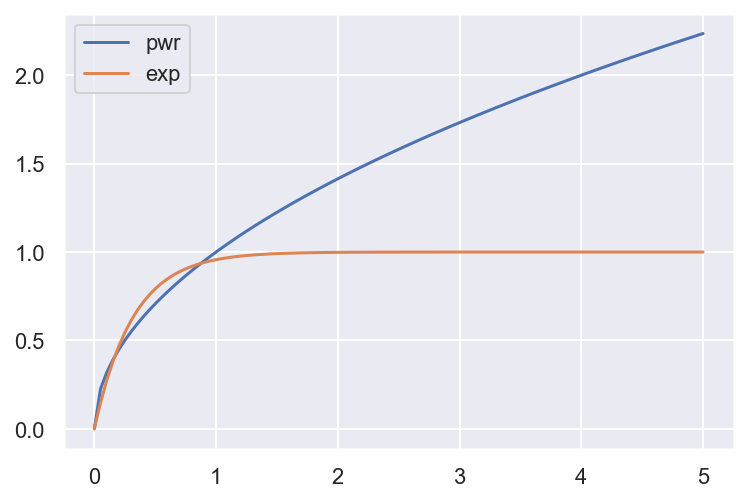

In [6]:
x = np.linspace(0, 5, 100)
y_pow = x**0.5
y_exp = 1 - np.exp(-3.14*x)

fig, ax = plt.subplots()
ax.plot(x, y_pow, label='pwr')
ax.plot(x, y_exp, label='exp')
ax.legend()
plt.show()

### Data generated with exp, fitted with pow

In [11]:
x = np.linspace(0, 5, 100)
y = 1 - np.exp(-2.725*x)
def objective(alpha):
    y_hat = x**np.exp(alpha) # np.power(x**np.exp(alpha)
    return np.sum(np.power(y_hat - y, 2))

res = scipy.optimize.minimize(objective, x0=0)
print(np.exp(res.x))

[0.06084469]


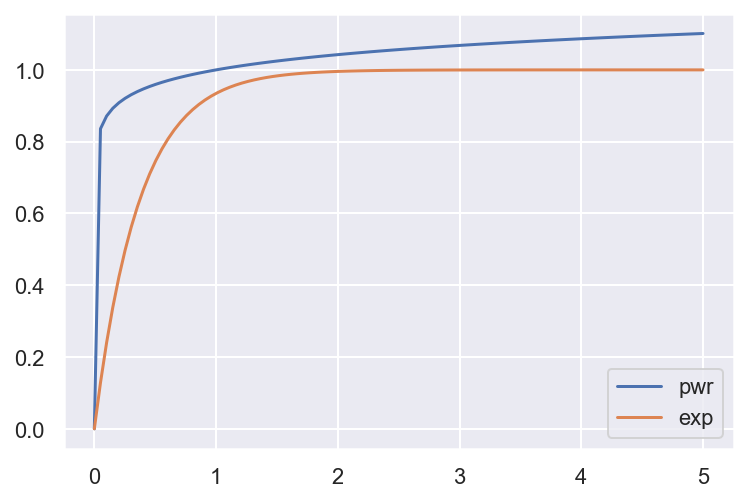

In [12]:
x = np.linspace(0, 5, 100)
y_pow = x**0.06
y_exp = 1 - np.exp(-2.725*x)

fig, ax = plt.subplots()
ax.plot(x, y_pow, label='pwr')
ax.plot(x, y_exp, label='exp')
ax.legend()
plt.show()

# Generate choice data

In [27]:
def generate_data(u, seed=1234):
    np.random.seed(seed)

    task = pd.DataFrame(np.random.uniform(0, 5, size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
    task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
    task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

    seu0 = task.p0 * u(task.x0)
    seu1 = task.p1 * u(task.x1)

    diff_eu = seu1 - seu0
    task['diff_eu'] = diff_eu

    p_choice_1 = expit(3.333*diff_eu)
    choice = np.zeros(p_choice_1.shape, dtype=int)
    choice[:] = p_choice_1 > np.random.random(size=choice.shape)
    task["choice"] = choice

    n = 100
    task = task.sample(n=n, replace=False)
    task = task.sort_values(by="diff_eu")
    task.reset_index(inplace=True, drop=True)

    p0 = task.p0.values
    p1 = task.p1.values
    x0 = task.x0.values
    x1 = task.x1.values
    choices = task.choice.values
    diff_eu = task.diff_eu.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)

    return x_sorted, p_sorted, undo_sorted, choices

# Model discrepancy

In [25]:
def build_model(u, x_sorted, p_sorted, undo_sorted, choices):
    with pm.Model() as model:

        ρ = pm.InverseGamma('ρ', 2, 2)
        η = pm.HalfCauchy('η', 5)

        X = x_sorted.reshape(-1, 1)
        uX = u(X)

        M = pm.gp.mean.Constant(uX.flatten())
        K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)

        gp = pm.gp.Latent(mean_func=M, cov_func=K)
        f = gp.prior("f", X=X)

        est_eu =  p_sorted * f    
        est_eu_unsorted = est_eu[undo_sorted]
        n = len(choices)
        diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])

        est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit(3.333*diff_eu_hat))
        choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=choices)
    return model, gp

# Using good model: data = exp, fit = exp

In [31]:
u_data = lambda x: 1 - np.exp(-2.725*x)
x_sorted, p_sorted, undo_sorted, choices = generate_data(u=u_data)

In [33]:
model, gp = build_model(u=u_data, x_sorted=x_sorted, p_sorted=p_sorted, undo_sorted=undo_sorted, choices=choices)

with model:
    mean_field = pm.fit(method="advi", n=10000)

Finished [100%]: Average Loss = 41.854


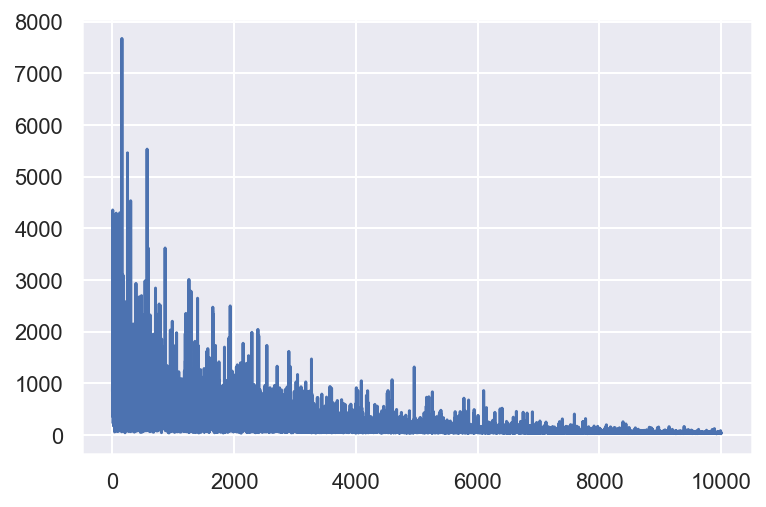

In [34]:
plt.plot(mean_field.hist);

In [35]:
trace_vi = mean_field.sample(1000)
with model:
    pred_samples = pm.sample_posterior_predictive(trace_vi, var_names=["f"])

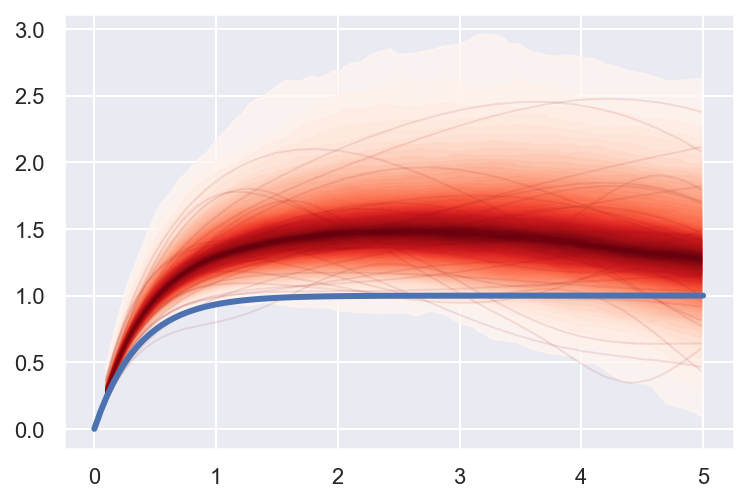

In [36]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(np.linspace(0, 5, 100), u_data(np.linspace(0, 5, 100)), lw=3, color='C0')

# Using BAD model: data = exp, inf = pow

In [29]:
u_data = lambda x: 1 - np.exp(-2.725*x)
x_sorted, p_sorted, undo_sorted, choices = generate_data(u=u_data)

In [30]:
u_model = lambda x: x**0.06
model, gp = build_model(u=u_model, x_sorted=x_sorted, p_sorted=p_sorted, undo_sorted=undo_sorted, choices=choices)

with model:
    mean_field = pm.fit(method="advi", n=10000)

Finished [100%]: Average Loss = 58.582


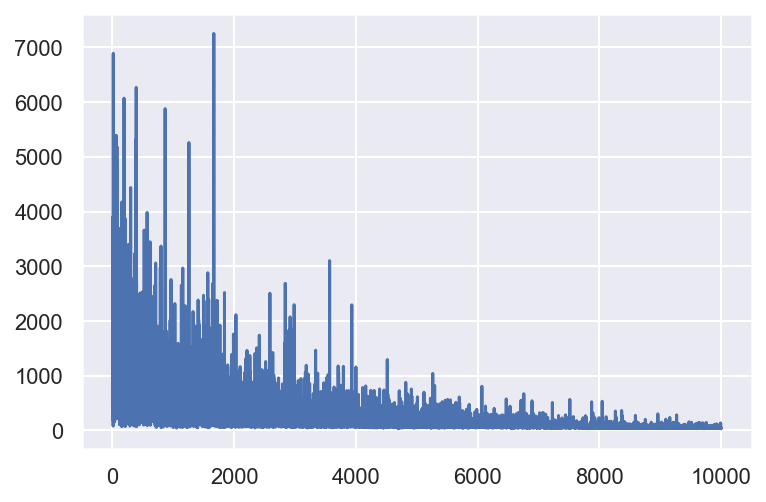

In [31]:
plt.plot(mean_field.hist);

In [32]:
trace_vi = mean_field.sample(1000)
with model:
    pred_samples = pm.sample_posterior_predictive(trace_vi, var_names=["f"])

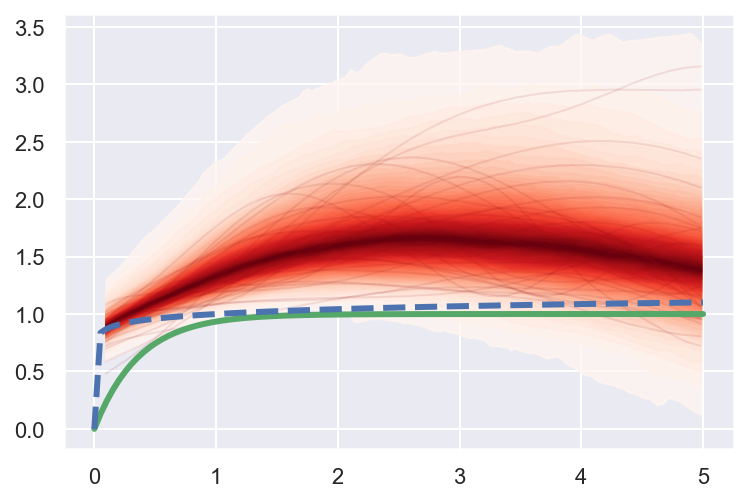

In [33]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(np.linspace(0, 5, 100), u_data(np.linspace(0, 5, 100)), lw=3, color='C2')
ax.plot(np.linspace(0, 5, 100), u_model(np.linspace(0, 5, 100)), lw=3, color='C0', ls='--')

# Using good model: data = pow, fit = pow

In [41]:
x_sorted, p_sorted, undo_sorted, choices = generate_data(u=u_data)

In [42]:
u_data = lambda x: x**0.5
x_sorted, p_sorted, undo_sorted, choices = generate_data(u=u_data)

In [43]:
model, gp = build_model(u=u_data, x_sorted=x_sorted, p_sorted=p_sorted, undo_sorted=undo_sorted, choices=choices)

with model:
    mean_field = pm.fit(method="advi", n=10000)

Finished [100%]: Average Loss = 43.825


Text(0, 0.5, 'loss')

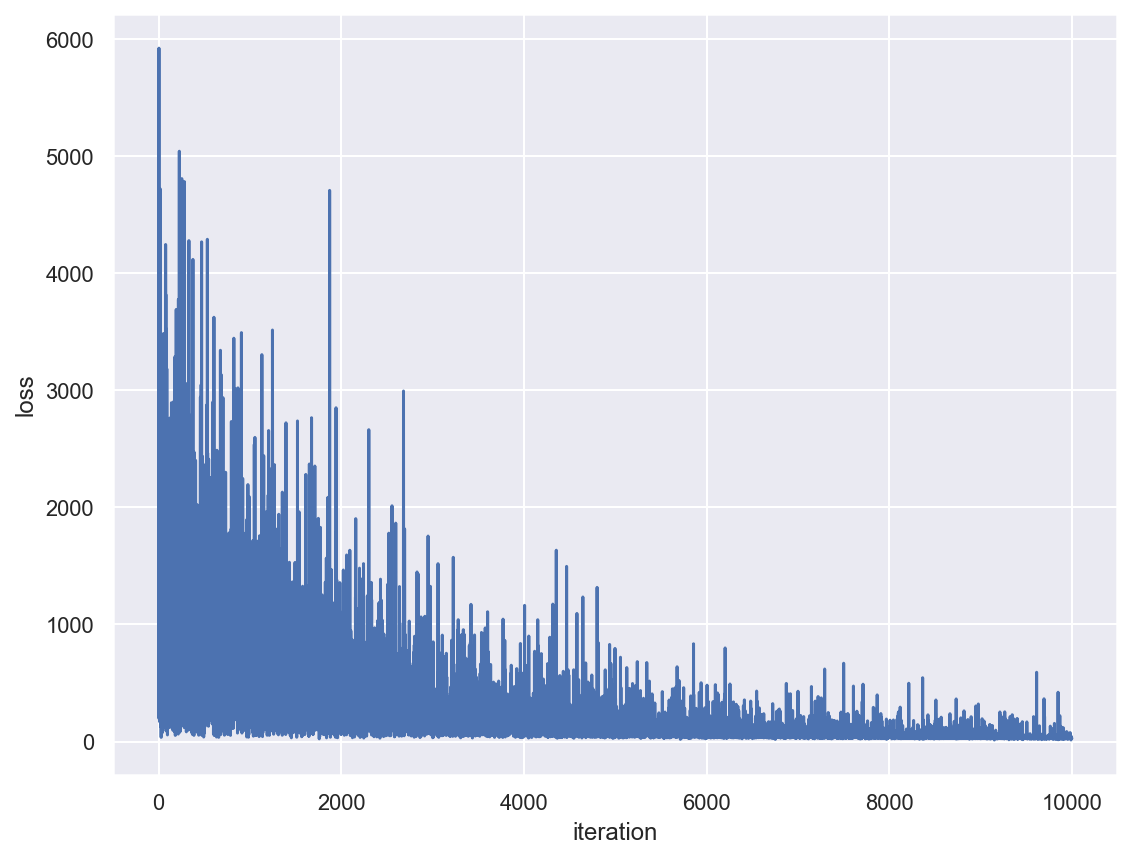

In [51]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(mean_field.hist)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")

In [45]:
trace_vi = mean_field.sample(1000)
with model:
    pred_samples = pm.sample_posterior_predictive(trace_vi, var_names=["f"])

[]

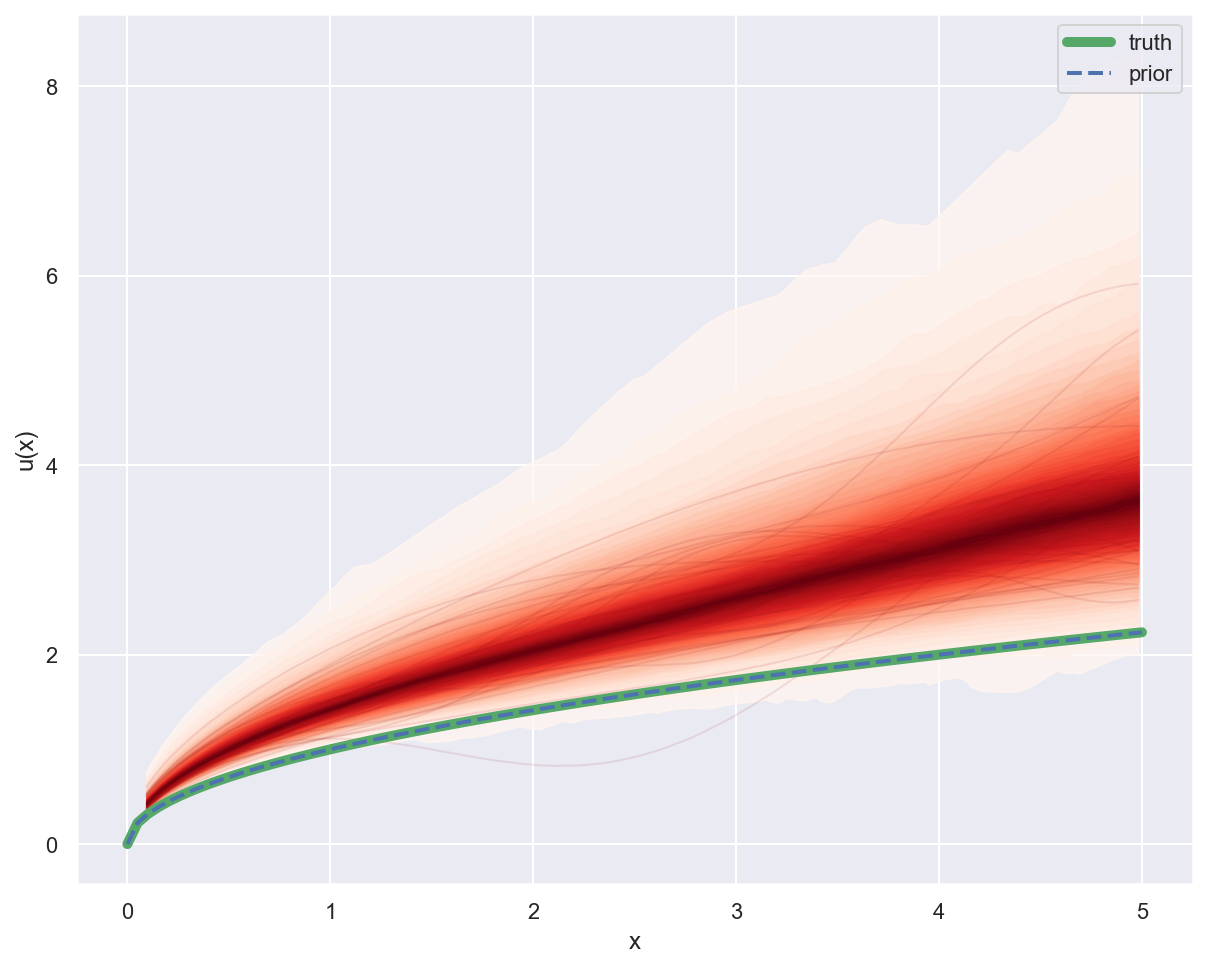

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(np.linspace(0, 5, 100), u_data(np.linspace(0, 5, 100)), lw=5, color='C2', label="truth")
ax.plot(np.linspace(0, 5, 100), u_data(np.linspace(0, 5, 100)), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend()
plt.plot()

# Using BAD model: data = pow, inf = exp

In [52]:
u_model = lambda x: 1 - np.exp(-3.14*x) 
model, gp = build_model(u=u_model, x_sorted=x_sorted, p_sorted=p_sorted, undo_sorted=undo_sorted, choices=choices)

with model:
    mean_field = pm.fit(method="advi", n=10000)

Finished [100%]: Average Loss = 42.818


Text(0, 0.5, 'loss')

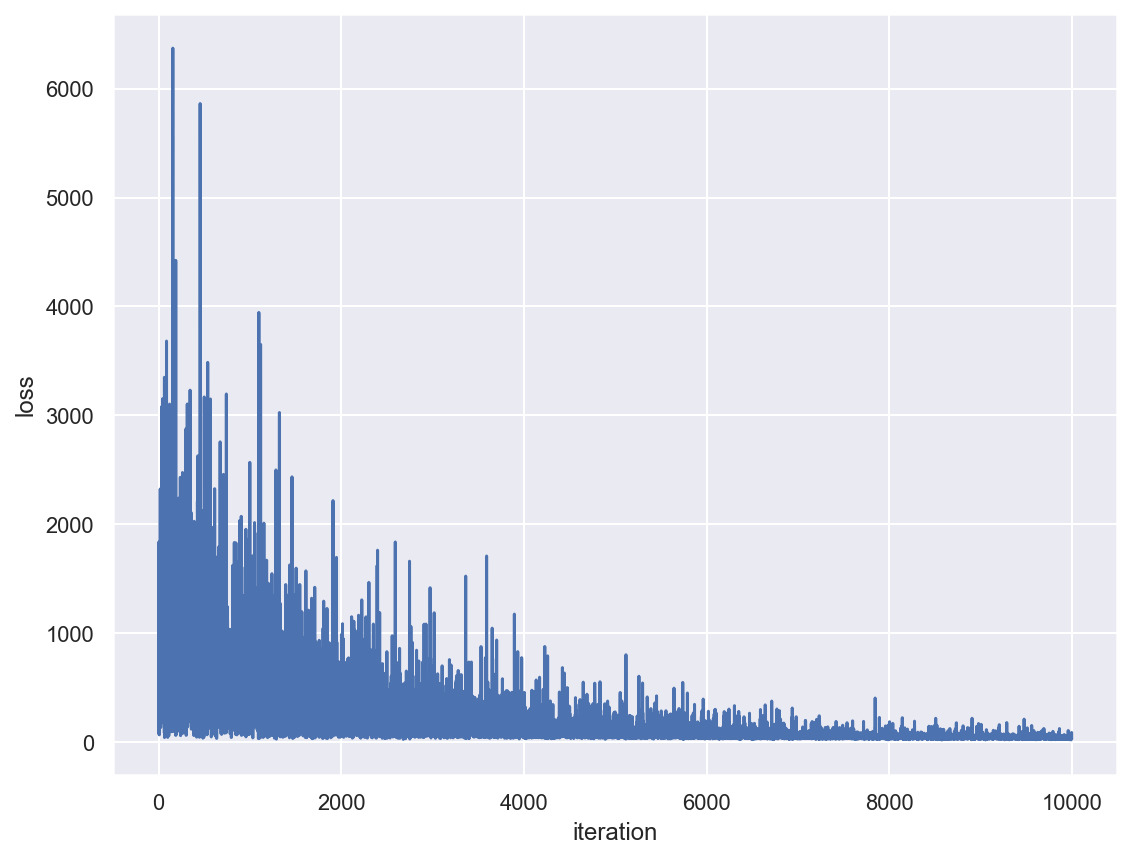

In [53]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(mean_field.hist)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")

In [54]:
trace_vi = mean_field.sample(1000)
with model:
    pred_samples = pm.sample_posterior_predictive(trace_vi, var_names=["f"])

[]

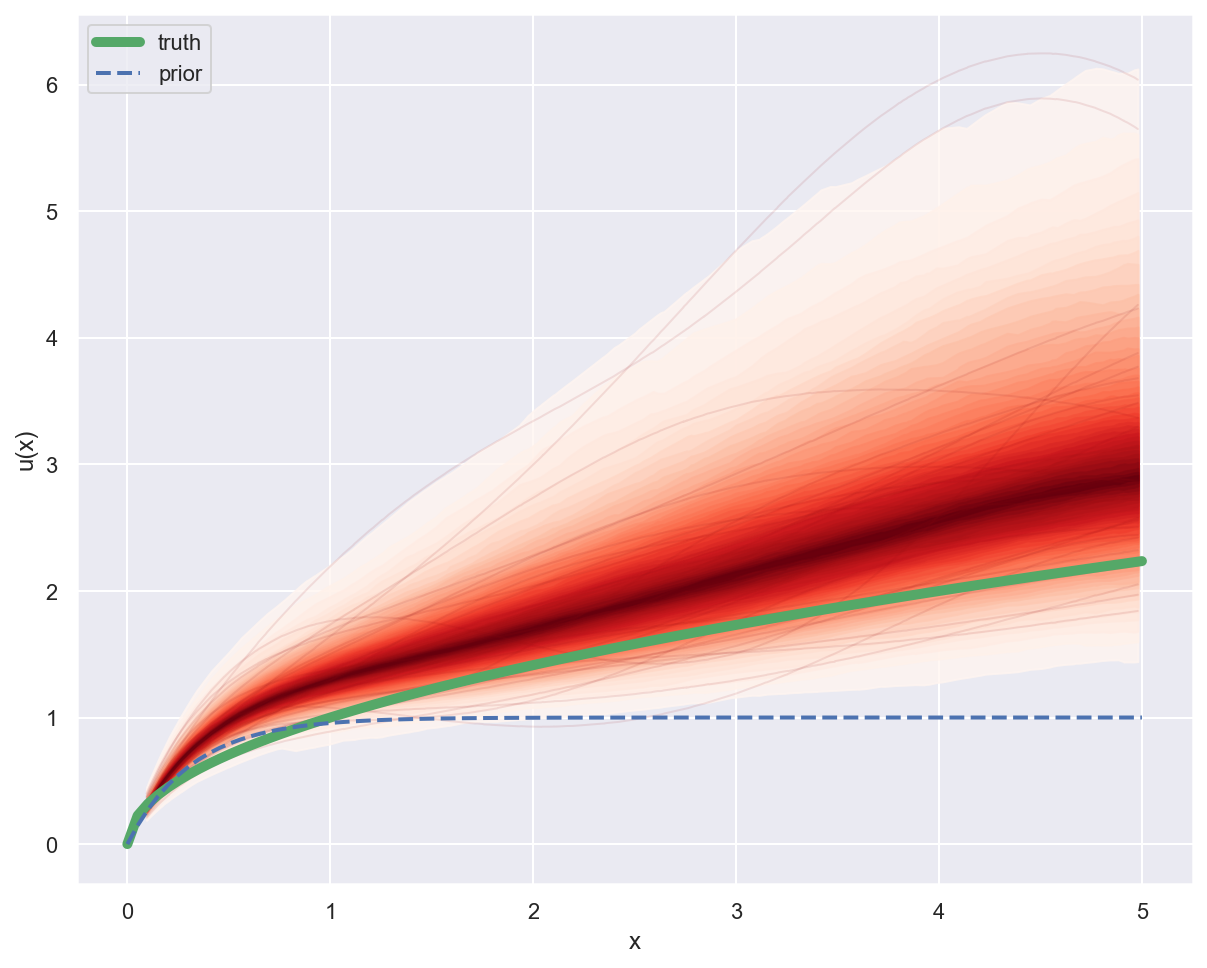

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(np.linspace(0, 5, 100), u_data(np.linspace(0, 5, 100)), lw=5, color='C2', label="truth")
ax.plot(np.linspace(0, 5, 100), u_model(np.linspace(0, 5, 100)), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend()
plt.plot()

# Trials

In [59]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [27]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

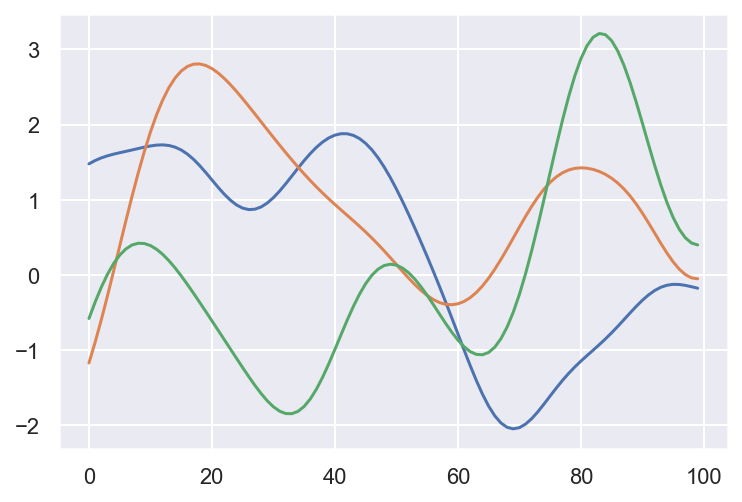

In [28]:
fig, ax = plt.subplots()
ax.plot(samples.T)

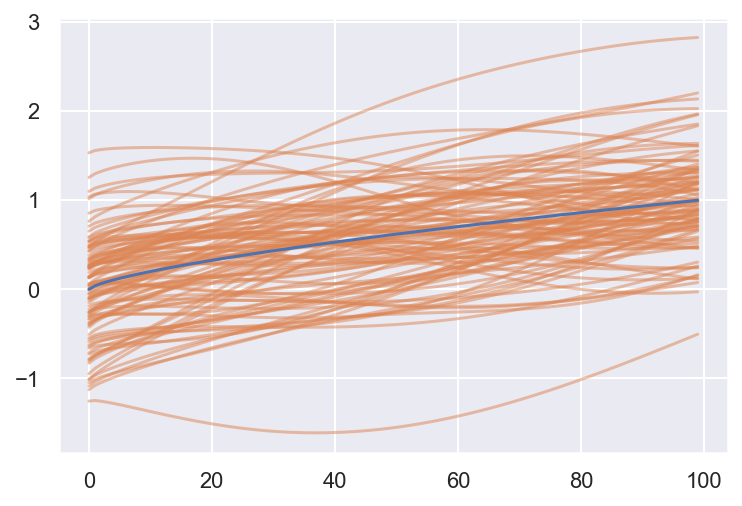

In [153]:
X = np.linspace(0, 1, 100).reshape(-1, 1)

# Mean and covariance of the prior
mu = X**(0.7)
cov = kernel(X, X, sigma_f=0.5, l=0.5)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 100)

fig, ax = plt.subplots()
ax.plot(samples.T, color='C1', alpha=0.5)
ax.plot(mu)
plt.show()

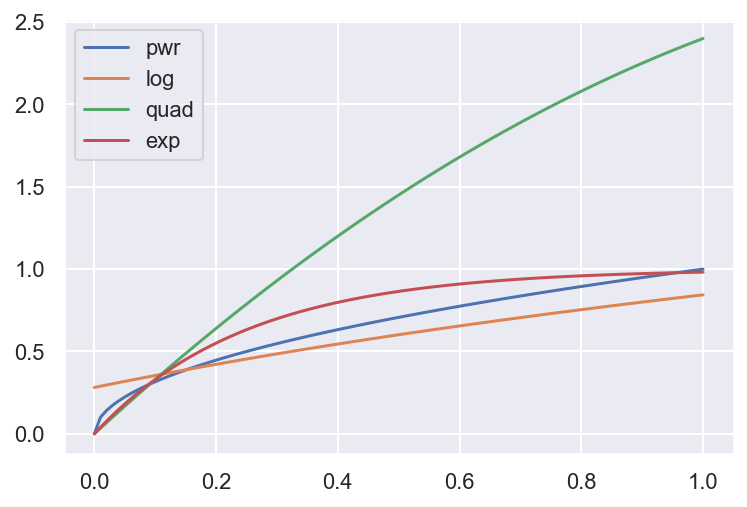

In [154]:
x = np.linspace(0, 1, 100)
y1 = x**.5
y2 = np.log(1.325 + x)
y3 = 3.4 * x - x**2
y4 = 1 - np.exp(-4.0*x)

fig, ax = plt.subplots()
ax.plot(x, y1, label='pwr')
ax.plot(x, y2, label='log')
ax.plot(x, y3, label='quad')
ax.plot(x, y4, label='exp')
ax.legend()
plt.show()

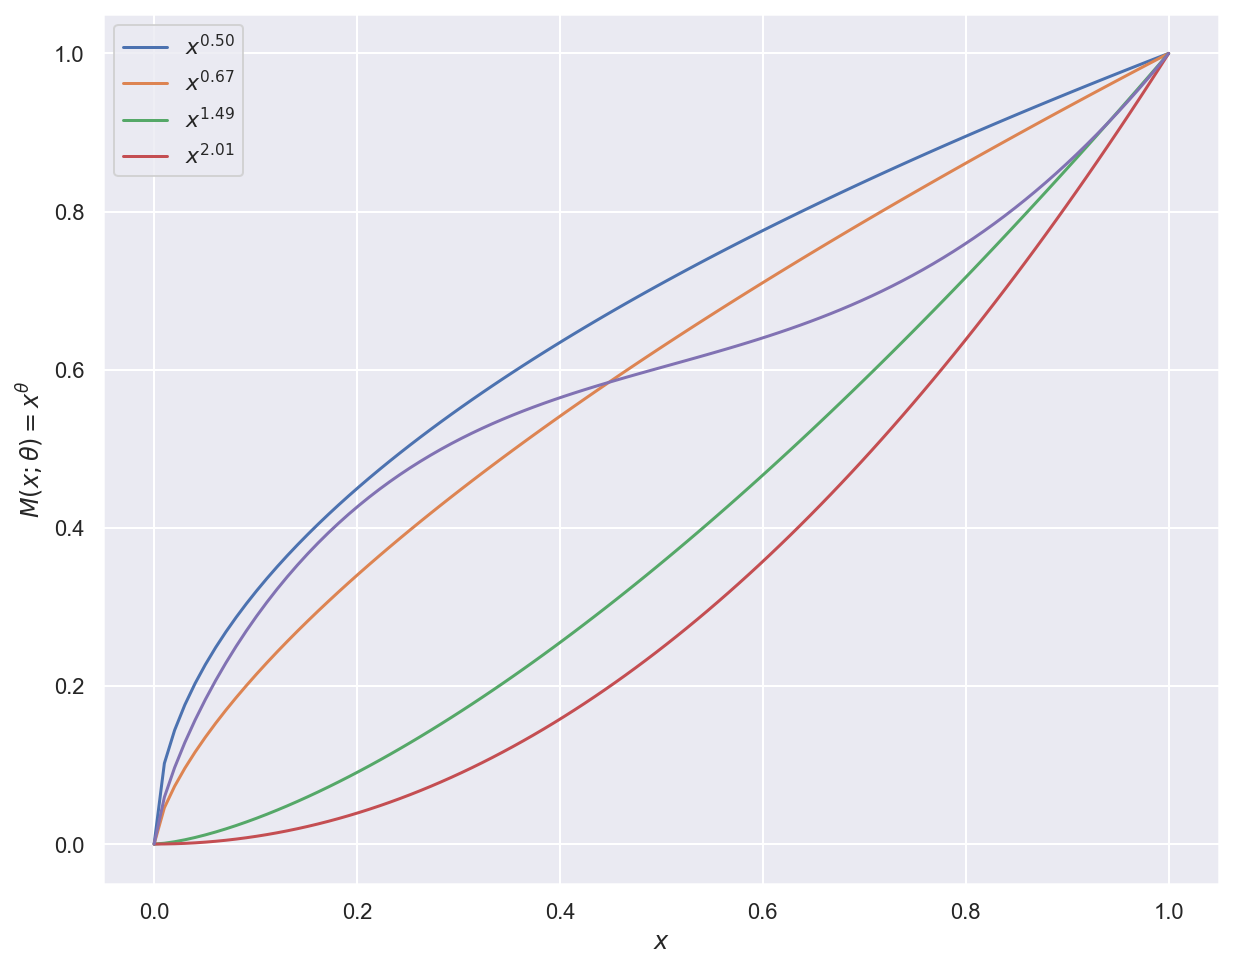

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 1, 100)
for alpha in -0.7, -0.4, 0.4, 0.7, :
    ax.plot(x, x**np.exp(alpha), label=r"$x^{"+ f"{np.exp(alpha):.2f}" +"}$")

X = x.reshape(-1, 1)
# Mean and covariance of the prior
mu = X**(0.7)
cov = kernel(X, X, sigma_f=1, l=0.8)

# Draw three samples from the prior
np.random.seed(1245)
sample = np.random.multivariate_normal(mu.ravel(), cov, 1).flatten()
ax.plot(x, (sample - np.min(sample))/(np.max(sample)-np.min(sample)) )

ax.set_xlabel("$x$")
ax.set_ylabel(r"$M(x; \theta) = x^{\theta}$")
ax.legend()

Text(0, 0.5, '$f(x)$')

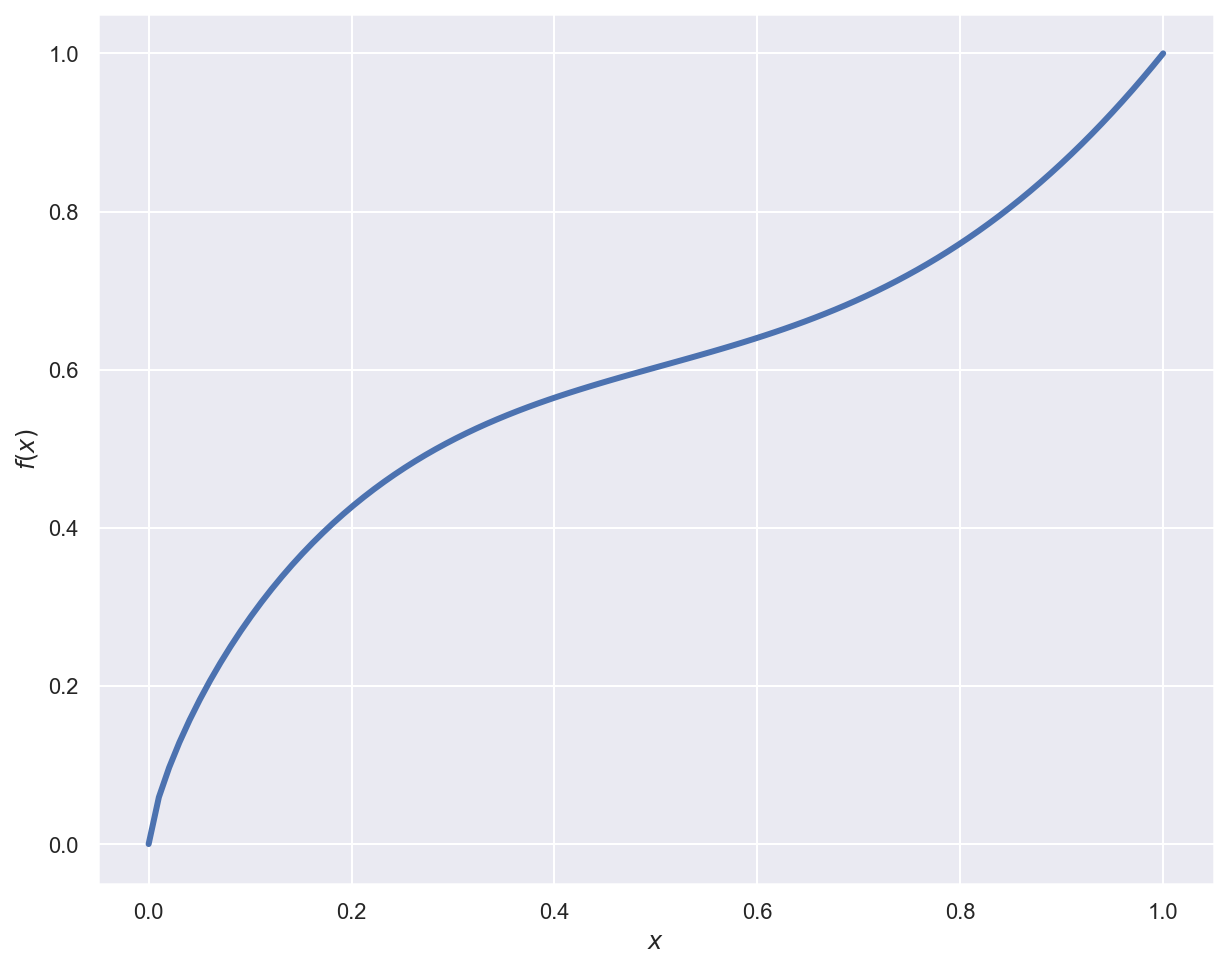

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 1, 100)

X = x.reshape(-1, 1)
# Mean and covariance of the prior
mu = X**(0.7)
cov = kernel(X, X, sigma_f=1, l=0.8)

# Draw three samples from the prior
np.random.seed(1245)
sample = np.random.multivariate_normal(mu.ravel(), cov, 1).flatten()
f = (sample - np.min(sample))/(np.max(sample)-np.min(sample)) 
ax.plot(x, f, lw=3)

ax.set_xlabel("$x$")
ax.set_ylabel(r"$f(x)$")

In [79]:
def objective(param):
    alpha, = param
    return np.sum((f - x**np.exp(alpha))**2)

res = scipy.optimize.minimize(fun=objective, x0=(0, ))
res

      fun: 0.46533382204697493
 hess_inv: array([[0.07952128]])
      jac: array([6.2957406e-07])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([-0.44375483])

Text(0, 0.5, '$M(x; \\theta^*)$')

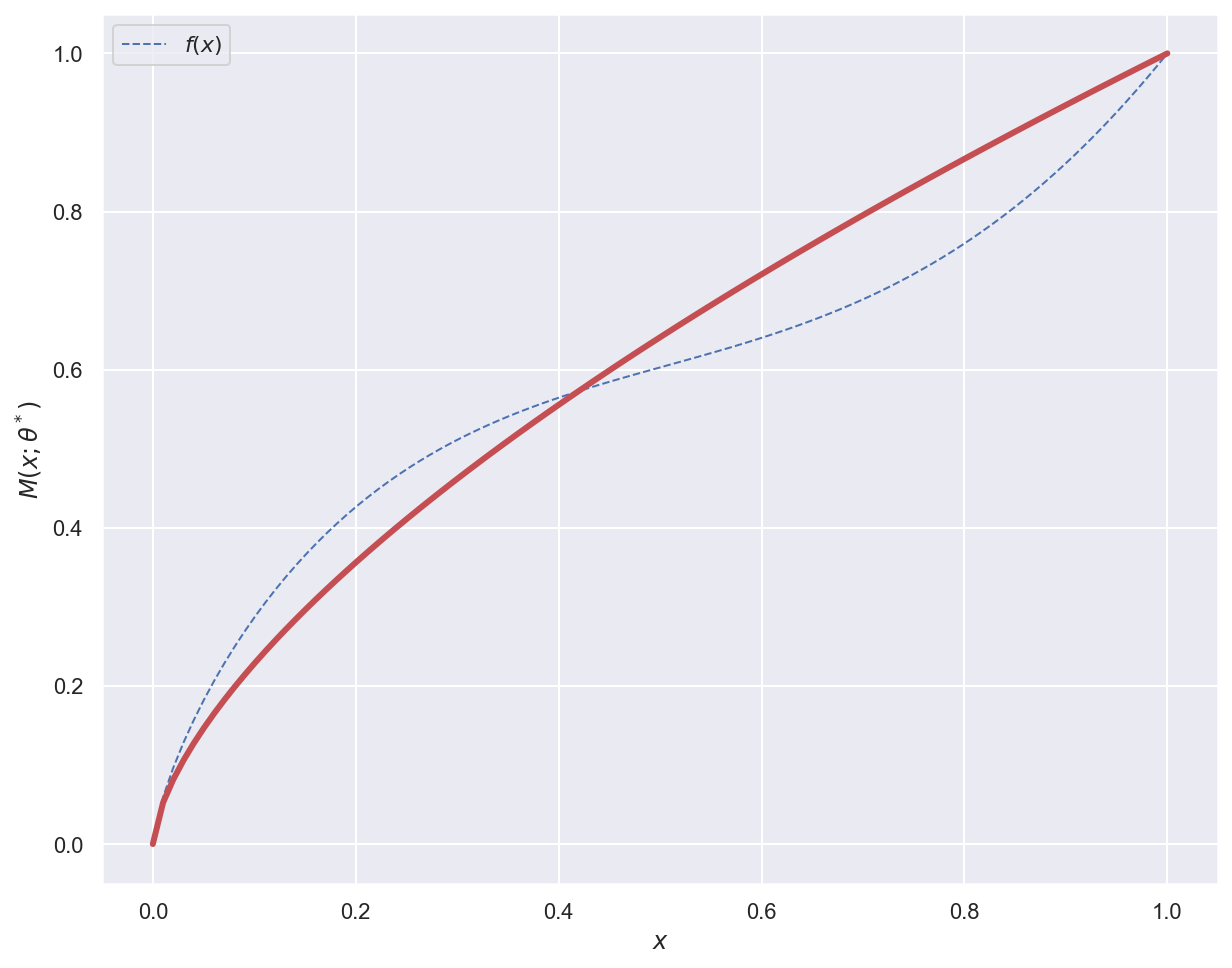

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 1, 100)

X = x.reshape(-1, 1)
# Mean and covariance of the prior
mu = X**(0.7)
cov = kernel(X, X, sigma_f=1, l=0.8)

# Draw three samples from the prior
ax.plot(x, f, lw=1, ls='--', label=r'$f(x)$')
ax.plot(x, x**np.exp(res.x), color="C3", lw=3)

ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$M(x; \theta^*)$")

In [135]:
def M(x, param):
    alpha, beta = param
    return np.exp(-expit(beta)*(-np.log(x))**expit(alpha))

def objective(param):
    return np.sum((f - M(x, param))**2)

res = scipy.optimize.minimize(fun=objective, x0=(0,0))
res

      fun: 0.09460501104963831
 hess_inv: array([[ 2.16714159, -0.07401602],
       [-0.07401602,  0.53378135]])
      jac: array([4.37721610e-08, 1.44354999e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([0.75879441, 0.69085876])

Text(0, 0.5, '$M^*(x; \\theta^*)$')

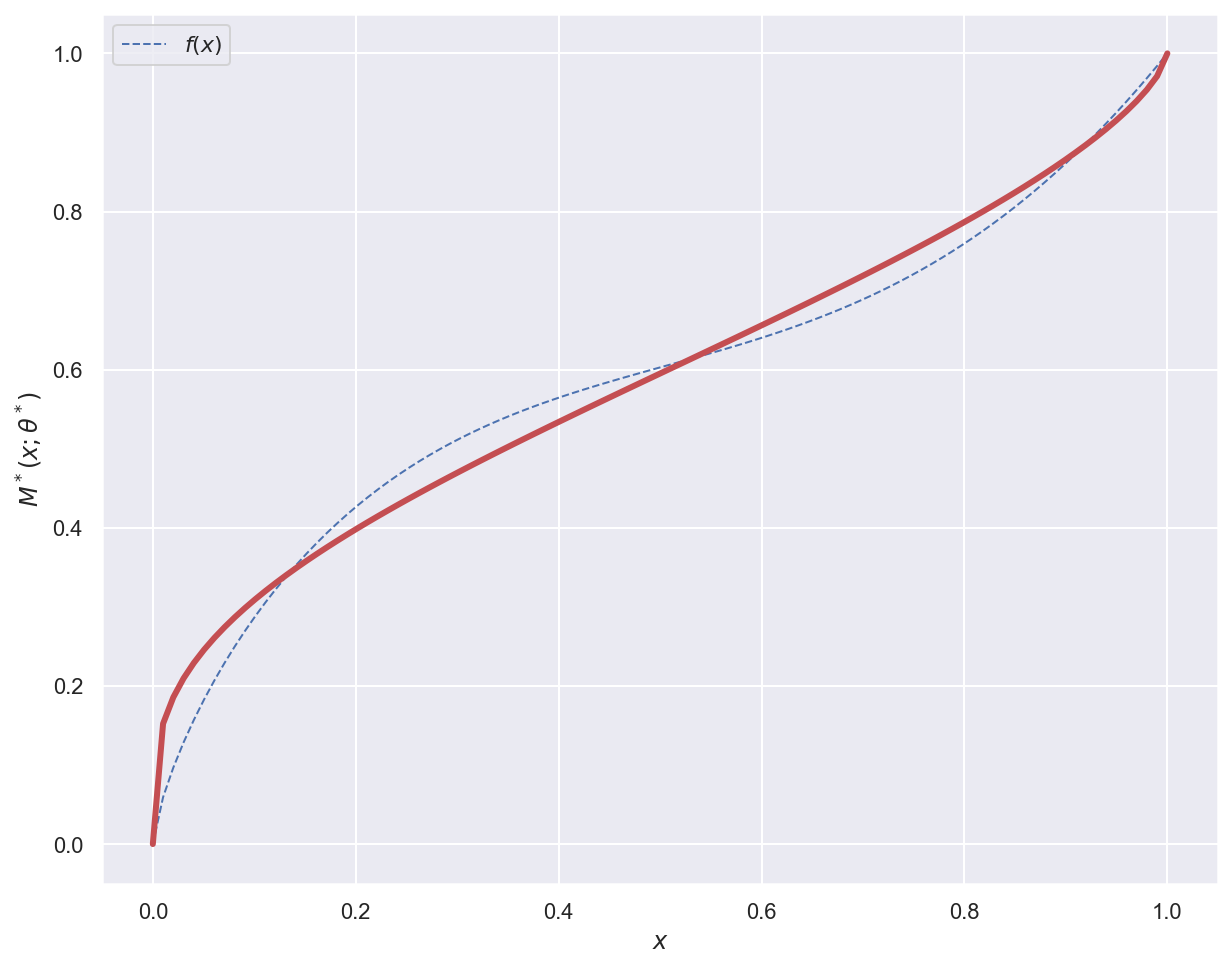

In [137]:
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(0, 1, 100)

# Draw three samples from the prior
ax.plot(x, f, lw=1, ls='--', label=r'$f(x)$')
ax.plot(x, M(x, res.x), color="C3", lw=3)

ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$M^*(x; \theta^*)$")